In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tabulate import tabulate
import seaborn as sns
import scikitplot as skplt
from numpy import percentile
import math


#pandas
from pandas.plotting import parallel_coordinates
from datetime import date, datetime

#sklearn
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, RobustScaler, StandardScaler

from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import learning_curve

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix, roc_curve, auc
from sklearn.metrics import roc_auc_score, precision_score, recall_score, make_scorer
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
#scikitplot
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall
from scikitplot.metrics import plot_lift_curve
from scikitplot.metrics import plot_cumulative_gain
import scikitplot 
#mlxtend
from mlxtend.plotting import plot_decision_regions

#matplotlib
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib import pyplot

#seaborn
import seaborn as sns
#scipy
import scipy.stats as stats
from scipy.stats import shapiro, mannwhitneyu, normaltest, kstest
from scipy.stats import boxcox, yeojohnson
from pyod.models.knn import KNN

from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import StandardScaler

# Data Preparation

In [2]:
train = pd.read_csv('../data/reduced_cleaned_files/train_reduced_cleaned_5.csv')
X_train = train.drop(['Activity'], axis=1)

y_train = train['Activity']
y_train = pd.DataFrame(y_train)
print('X_train and y_train : ({},{})'.format(X_train.shape, y_train.shape))

X_train and y_train : ((7352, 200),(7352, 1))


In [3]:
X_test = pd.read_csv('../data/reduced_files/X_test_reduced_UFS.csv')
y_test = pd.read_csv('../data/csv_files/y_test.csv')
#X_train = train.drop(['subject', 'Activity','ActivityName'], axis=1)

#y_train = train['Activity']
#y_train = pd.DataFrame(y_train)
print('X_test and y_test : ({},{})'.format(X_test.shape, y_test.shape))

X_test and y_test : ((2947, 200),(2947, 1))


In [4]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Funzioni da utilizzare

In [5]:
# Parametri globali ##----AGGIUNTI DOPO-----##

n_iter = 10
scoring = 'f1_weighted'
random_state = 42

# test_n_splits = 9
test_n_splits = 3

model = KNeighborsClassifier()
model_name = "KNeighborsClassifier"

v_or_t_flag = "TST"
cmap = plt.cm.Blues
color = "blue"

In [6]:
##---AGGIUNTI DOPO----##

def model_grid(X_tr ):
    grid = dict()
    sqrt_records = round(math.sqrt(X_train.shape[1]))
    k_range = list(range(2, sqrt_records+1, 2))
    grid['model__n_neighbors'] = k_range
    #grid['model__max_features'] = [None, 'auto', 'sqrt', 'log2']
    grid['model__weights'] = ['uniform', 'distance']
    # grid['model__min_samples_split'] = [0.1, 0.01, 0.001] # ceil(min_samples_split * n_samples)
    grid['model__min_samples_split'] = [2, 5, 20]
    # grid['model__min_samples_split'] = list(np.arange(2, 101))
    # grid['model__min_samples_leaf'] = [0.05, 0.005, 0.0005] # ceil(min_samples_split * n_samples)
    grid['model__min_samples_leaf'] = [2, 5, 20]
    # grid['model__min_samples_leaf'] = list(np.arange(2, 101))
    #grid['model__class_weight'] = ['balanced', None]
    return grid

def get_tuned_model(X_tr, y_tr, params):
    
    model_params = list(model_grid(X_tr).keys())
    # retrieve best hyperameters
    tmp_model_hyperparameters = dict((k, params[k]) for k in model_params if k in params)
    model_hyperparameters = {}
    for key, value in tmp_model_hyperparameters.items():
        key = key.split('model__')[1].replace("'", "")
        model_hyperparameters[key] = value
        
    tuned_model =  model.set_params(**model_hyperparameters)
    tuned_model.fit(X_tr, y_tr.values.ravel())
    return tuned_model

def plot_confusion_matrix(cm, classes, normalize):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title("%s\'s %s classification report" % (model_name.capitalize(), v_or_t_flag.upper()))
    # plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    
    plt.grid(False)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
def plot_classification_report(y_ts, y_pred):
    model_report = classification_report(y_ts, 
                                       y_pred,
                                       # target_names=['Studio Recording', 'Live Recording'],
                                       output_dict=True)
    model_r = pd.DataFrame(model_report).iloc[:-1, :].T
    sns.heatmap(model_r, annot=True, cmap=cmap, cbar=False)
    plt.title("%s\'s %s confusion matrix" % (model_name.capitalize(), v_or_t_flag.upper()))
    plt.show()
    
def plot_decision_boundary(X_tr, y_tr, model):
    pca = PCA(n_components=2)
    best_visualisation_scaler = StandardScaler()
    scaled_X_tr = best_visualisation_scaler.fit_transform(X_tr)
    X = pca.fit_transform(scaled_X_tr)
    # X = pca.fit_transform(X_tr)
    y = y_tr.values.ravel()

    model.fit(X, y)
    plt.figure(figsize=(8, 5))
    fig = plot_decision_regions(X=X, y=y, clf=model, legend=2)
    plt.xlabel("PCA component 1")
    plt.ylabel("PCA component 2")
    plt.title("%s's %s decision boundary" % (model_name, v_or_t_flag))
    plt.legend(loc='best')
    plt.grid(False)
    plt.show()


In [7]:
def draw_roc_curve_mutliclass(y_test, y_pred):
    lb = LabelBinarizer()
    lb.fit(y_test)
    lb.classes_.tolist()

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    by_test = lb.transform(y_test)
    by_pred = lb.transform(y_pred)
    for i in range(6):
        fpr[i], tpr[i], _ = roc_curve(by_test[:, i], by_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    roc_auc = roc_auc_score(by_test, by_pred, average=None)
    plt.figure(figsize=(8, 5))
    
    for i in range(6):
        plt.plot(fpr[i], tpr[i], 
                 label='%s ROC curve (area = %0.2f)' % (lb.classes_.tolist()[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=20)
    plt.ylabel('True Positive Rate', fontsize=20) 
    plt.tick_params(axis='both', which='major', labelsize=22)
    plt.legend(loc="lower right", fontsize=14, frameon=False)
    plt.show()

In [8]:
def plot_learning_curve(pipeline, X, y, scorer='accuracy', cv=5, train_sizes=np.linspace(.1, 1.0, 5), 
                        shuffle=False, random_state=None):

    train_sizes, train_scores, test_scores = learning_curve(pipeline, X, y, train_sizes=train_sizes, cv=cv,
                                                            scoring=scorer, n_jobs=-1, shuffle=shuffle,
                                                            random_state=random_state)

    mean_train_score = np.mean(train_scores, axis=1)
    std_train_score = np.std(train_scores, axis=1)
    mean_test_score = np.mean(test_scores, axis=1)
    std_test_score = np.std(test_scores, axis=1)

    plt.title('learning curve')
    plt.xlabel('training set size')
    plt.ylabel('score')

    plt.plot(train_sizes, mean_train_score, label='train score', color='navy', marker='.', lw=2)
    plt.fill_between(train_sizes, mean_train_score + std_train_score,
                     mean_train_score - std_train_score, color='navy', alpha=0.2)
    plt.plot(train_sizes, mean_test_score, label='cross-validation score', color='darkorange', marker='.', lw=2)
    plt.fill_between(train_sizes, mean_test_score + std_test_score,
                     mean_test_score - std_test_score, color='darkorange', alpha=0.2)

    plt.legend(loc='lower right').get_frame().set_facecolor('white')

# Parameter tuning

In [9]:
scalers_to_test = [MinMaxScaler(), MaxAbsScaler(), RobustScaler(), StandardScaler()]
sqrt_records = round(math.sqrt(X_train.shape[1]))
k_range = list(range(2, sqrt_records+1, 2)) #setting k= square root of 561 = 24

# per randomized
params1 = {'scaler': scalers_to_test,
          'n_neighbors': k_range,
          'weights': ['uniform', 'distance']#,'p': [1, 2]
          }

# per gridsearch
params2 = {'n_neighbors': np.arange(1, 10 + 1),
           'weights':['uniform', 'distance']}

params3 = {'n_neighbors': k_range,
          'weights': ['uniform', 'distance']
          }

## 1. GridSearchCV

Fitting 3 folds for each of 14 candidates, totalling 42 fits

{'n_neighbors': 14, 'weights': 'uniform'}
KNeighborsClassifier(n_neighbors=14)

Accuracy 0.8982015609093994
F1-score 0.8976464908581551
Precision: 0.9026265088035667
Recall: 0.8982015609093994
              precision    recall  f1-score   support

           1       0.83      0.96      0.89       496
           2       0.85      0.85      0.85       471
           3       0.96      0.78      0.86       420
           4       0.92      0.83      0.88       491
           5       0.86      0.93      0.90       532
           6       1.00      1.00      1.00       537

    accuracy                           0.90      2947
   macro avg       0.90      0.89      0.89      2947
weighted avg       0.90      0.90      0.90      2947


=== CROSS VALIDATION SCORES ===
Accuracy: 0.9060 (+/- 0.032)
F1-score: 0.9015 (+/- 0.035)

=== CONFUSION MATRIX ===


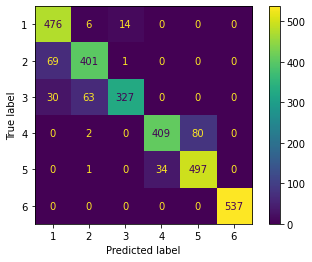


=== Altre grafiche per visualizzazione===


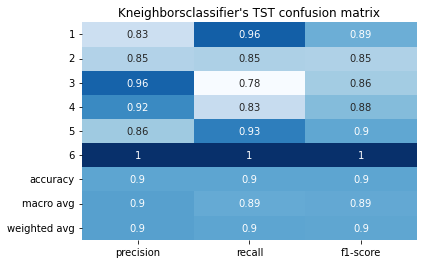

C:\Users\info\anaconda3\lib\site-packages\mlxtend\plotting\decision_regions.py:274: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x=x_data,


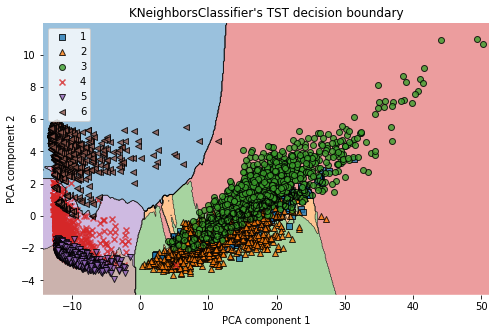


=== CURVES===


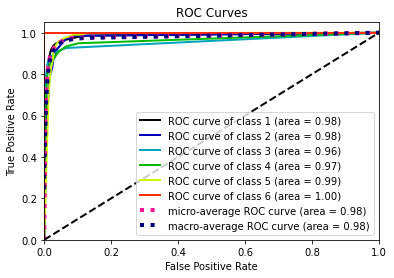

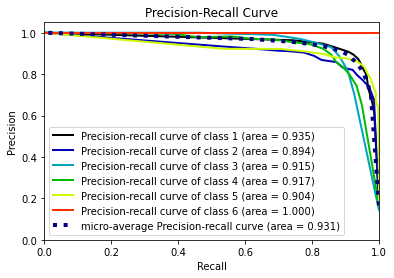

In [10]:
model = KNeighborsClassifier()

k_fold = StratifiedKFold(n_splits=3) 
grid_search = GridSearchCV(model, params3, n_jobs = -1, verbose =3, cv = k_fold, refit = 'f1_weighted')
grid_search.fit(X_train, y_train.values.ravel())

print()
print(grid_search.best_params_)
print(grid_search.best_estimator_)
print()

best_params = grid_search.best_params_
clf = grid_search.best_estimator_

y_pred = clf.predict(X_test)
y_score = clf.predict_proba(X_test)
tuned_model = get_tuned_model(X_train, y_train, best_params)
# Prima visualizzazione
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average='weighted'))
print('Precision:', metrics.precision_score(y_test, y_pred, average='weighted'))
print('Recall:', metrics.recall_score(y_test, y_pred, average='weighted'))
    
print(classification_report(y_test, y_pred))

# Seconda visualizzazione
print("\n=== CROSS VALIDATION SCORES ===")
scores = cross_val_score(clf, X_train, y_train.values.ravel(), cv=10)
print('Accuracy: %0.4f (+/- %0.3f)' % (scores.mean(), scores.std()))
scores = cross_val_score(clf, X_train, y_train.values.ravel(), cv=10, scoring='f1_macro')
print('F1-score: %0.4f (+/- %0.3f)' % (scores.mean(), scores.std()))


print("\n=== CONFUSION MATRIX ===")
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
                              
disp.plot()                      
#metrics.plot_confusion_matrix(clf, X_test, y_test)
plt.show()

print("\n=== Altre grafiche per visualizzazione===")
#cm = confusion_matrix(y_test, y_pred)
#plot_confusion_matrix(cm, clf.classes_, True)
plot_classification_report(y_test, y_pred)

plot_decision_boundary(X_train, y_train, tuned_model)  # passing random scaler

#draw_roc_curve_mutliclass(y_test, y_pred)

print("\n=== CURVES===")
skplt.metrics.plot_roc(y_test, y_score)

plot_precision_recall(y_test, y_score)
plt.show()

## 2. RandomizedGridSearch

Fitting 3 folds for each of 10 candidates, totalling 30 fits

{'weights': 'distance', 'n_neighbors': 14}
KNeighborsClassifier(n_neighbors=14, weights='distance')

Accuracy 0.8998982015609094
F1-score 0.8993411701008337
Precision: 0.9044413364897318
Recall: 0.8998982015609094
              precision    recall  f1-score   support

           1       0.84      0.95      0.89       496
           2       0.85      0.86      0.86       471
           3       0.95      0.80      0.87       420
           4       0.94      0.81      0.87       491
           5       0.85      0.95      0.90       532
           6       1.00      1.00      1.00       537

    accuracy                           0.90      2947
   macro avg       0.90      0.89      0.90      2947
weighted avg       0.90      0.90      0.90      2947


=== CROSS VALIDATION SCORES ===
Accuracy: 0.9089 (+/- 0.033)
F1-score: 0.9049 (+/- 0.037)

=== CONFUSION MATRIX ===


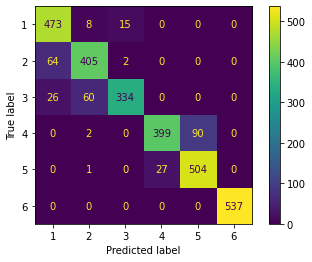


=== ROC CURVE===


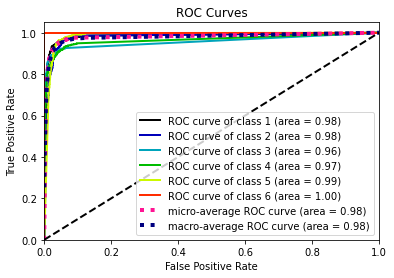

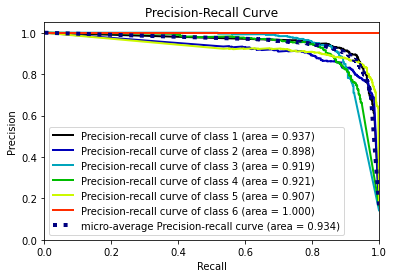

In [11]:
model = KNeighborsClassifier()

k_fold = StratifiedKFold(n_splits=3) 
randomized_search = RandomizedSearchCV(model, params3, n_jobs = -1, verbose =3, cv = k_fold, refit = 'f1_weighted')
randomized_search.fit(X_train, y_train.values.ravel())

print()
print(randomized_search.best_params_)
print(randomized_search.best_estimator_)
print()

best_params = randomized_search .best_params_
clf = randomized_search .best_estimator_

y_pred = clf.predict(X_test)
y_score = clf.predict_proba(X_test)

# Prima visualizzazione
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average='weighted'))
print('Precision:', metrics.precision_score(y_test, y_pred, average='weighted'))
print('Recall:', metrics.recall_score(y_test, y_pred, average='weighted'))
    
print(classification_report(y_test, y_pred))

# Seconda visualizzazione
print("\n=== CROSS VALIDATION SCORES ===")
scores = cross_val_score(clf, X_train, y_train.values.ravel(), cv=10)
print('Accuracy: %0.4f (+/- %0.3f)' % (scores.mean(), scores.std()))
scores = cross_val_score(clf, X_train, y_train.values.ravel(), cv=10, scoring='f1_macro')
print('F1-score: %0.4f (+/- %0.3f)' % (scores.mean(), scores.std()))


print("\n=== CONFUSION MATRIX ===")
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
                              
disp.plot()                      
#metrics.plot_confusion_matrix(clf, X_test, y_test)
plt.show()

print("\n=== ROC CURVE===")
skplt.metrics.plot_roc(y_test, y_score)

plot_precision_recall(y_test, y_score)
plt.show()

# DA FINIRE

In [ ]:
# fornisce delle versioni migliori dei plot
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall
from scikitplot.metrics import plot_cumulative_gain 
from scikitplot.metrics import plot_lift_curve